<a href="https://colab.research.google.com/github/koh-ts/human_activity_recognition/blob/master/human_activity_recognition_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
from sklearn import svm
from sklearn.model_selection import GroupKFold, cross_val_score, cross_validate
import pandas_profiling as pdp
from IPython.display import HTML
import lightgbm as lgb
from matplotlib import pyplot as plt
import pickle
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import GaussianNB
from collections import defaultdict

%matplotlib inline

In [0]:
class ModelExtractionCallback(object):
    """lightgbm.cv() から学習済みモデルを取り出すためのコールバックに使うクラス
    NOTE: 非公開クラス '_CVBooster' に依存しているため将来的に動かなく恐れがある
    """
    def __init__(self):
        self._model = None
    def __call__(self, env):
        # _CVBooster の参照を保持する
        self._model = env.model
    def _assert_called_cb(self):
        if self._model is None:
            # コールバックが呼ばれていないときは例外にする
            raise RuntimeError('callback has not called yet')
    @property
    def boosters_proxy(self):
        self._assert_called_cb()
        # Booster へのプロキシオブジェクトを返す
        return self._model
    @property
    def raw_boosters(self):
        self._assert_called_cb()
        # Booster のリストを返す
        return self._model.boosters
    @property
    def best_iteration(self):
        self._assert_called_cb()
        # Early stop したときの boosting round を返す
        return self._model.best_iteration
#from: https://blog.amedama.jp/entry/lightgbm-cv-model

Mount your Google Drive. In this notebook, we assume that 'report2' folder is placed directly under 'My Drive'.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Load the data.

In [0]:
root_dir="/content/drive/My Drive/report2/"
nsample = 3000

xraw_train = pd.read_csv(root_dir+"X_train.csv",header=None)
yraw_train = pd.read_csv(root_dir+"y_train.csv",header=None)
xraw_test = pd.read_csv(root_dir+"X_test.csv",header=None)

In [0]:
with open(root_dir + 'corr_done.txt', 'rb') as f:
  lis = pickle.load(f)

In [0]:
xraw_train = xraw_train.drop(lis, axis=1)
xraw_test = xraw_test.drop(lis, axis=1)

In [0]:
sub_train = pd.read_csv(root_dir + "subject_train.csv", header=None)

In [8]:
X_train = np.array(xraw_train)
y_train = np.array(yraw_train.ix[:,0])
X_test = np.array(xraw_test)
subject_train = np.array(sub_train)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  


In [0]:
# subject_train.shape
# X_train.shape

In [0]:
XTrain = X_train[:nsample,:] #use the first 3000 samples for training
yTrain = y_train[:nsample]
XVal = X_train[nsample:,:] #use the rests for validation
yVal = y_train[nsample:]
alldata = pd.concat([xraw_train, xraw_test], ignore_index=True)

Train a linear SVM classifier

In [0]:
group_kfold = GroupKFold(n_splits=15)
# for train_index, test_index in group_kfold.split(X_train, y_train, subject_train):
#   print(type(train_index), train_index)

In [30]:
print("Training linear SVM classifier.")
clf = svm.LinearSVC()
clf.fit(XTrain,yTrain)

Training linear SVM classifier.


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [67]:
temp = []
models = []
i = 0
for train_index, val_index in group_kfold.split(X_train, y_train, subject_train):
  print(type(train_index), train_index)
  clf_svm = svm.LinearSVC()
  x_svm_train, y_svm_val = X_train[train_index], y_train[train_index]
  clf.fit(x_svm_train, y_svm_val)
  models.append(('clf' + str(i), clf))
  yHat_val_svm = clf.predict(X_train[val_index])
  temp.append(yHat_val_svm)
  i += 1

<class 'numpy.ndarray'> [   0    1    2 ... 5077 5078 5079]


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


<class 'numpy.ndarray'> [   0    1    2 ... 5077 5078 5079]


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


<class 'numpy.ndarray'> [   0    1    2 ... 5077 5078 5079]


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


<class 'numpy.ndarray'> [   0    1    2 ... 5077 5078 5079]


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


<class 'numpy.ndarray'> [   0    1    2 ... 5077 5078 5079]


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


<class 'numpy.ndarray'> [   0    1    2 ... 4723 4724 4725]


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


<class 'numpy.ndarray'> [   0    1    2 ... 5077 5078 5079]


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


<class 'numpy.ndarray'> [   0    1    2 ... 5077 5078 5079]


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


<class 'numpy.ndarray'> [   0    1    2 ... 5077 5078 5079]


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


<class 'numpy.ndarray'> [   0    1    2 ... 5077 5078 5079]


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


<class 'numpy.ndarray'> [ 321  322  323 ... 5077 5078 5079]


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


<class 'numpy.ndarray'> [   0    1    2 ... 5077 5078 5079]


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


<class 'numpy.ndarray'> [   0    1    2 ... 5077 5078 5079]


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


<class 'numpy.ndarray'> [   0    1    2 ... 5077 5078 5079]


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


<class 'numpy.ndarray'> [   0    1    2 ... 5077 5078 5079]


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [69]:
models

[('clf0', LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
            intercept_scaling=1, loss='squared_hinge', max_iter=1000,
            multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
            verbose=0)),
 ('clf1', LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
            intercept_scaling=1, loss='squared_hinge', max_iter=1000,
            multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
            verbose=0)),
 ('clf2', LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
            intercept_scaling=1, loss='squared_hinge', max_iter=1000,
            multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
            verbose=0)),
 ('clf3', LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
            intercept_scaling=1, loss='squared_hinge', max_iter=1000,
            multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
            verbose=0)),
 ('clf4'

Evaluate training end validation scores.

In [12]:
yHatTrain = clf.predict(XTrain)
yHatVal = clf.predict(XVal)
print("Training score ", len((np.where(yHatTrain == yTrain))[0])*1.0/XTrain.shape[0])
print("Validation score ", len((np.where(yHatVal == yVal))[0])*1.0/XVal.shape[0])

Training score  0.995
Validation score  0.9134615384615384


In [0]:
train_data_set = lgb.Dataset(XTrain, yTrain)
valid_data_set = lgb.Dataset(XVal, yVal, reference=train_data_set)

params = {'boosting_type': 'gbdt',
          'objective': 'multiclass',
          'num_class': 7,
          'metric': {'multi_error'},
          'num_leaves': 16,
          'learning_rate': 0.04,
          'feature_fraction': 0.9, #0.9
          'bagging_fraction': 0.8, #0.8
          'bagging_freq': 7,
          'num_iterations': 100}

# params = {'objective': 'multiclass',
#           'num_class': 7,
#           'metric': {'multi_error'}}
extraction_cb = ModelExtractionCallback()
callbacks = [extraction_cb,]

In [15]:
train_data_for_cv = lgb.Dataset(X_train, y_train)
gbm_result = lgb.cv(params, train_data_for_cv, folds=group_kfold.split(X_train, y_train, subject_train), verbose_eval=True, callbacks=callbacks,)

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:430: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	cv_agg's multi_error: 0.428239 + 0.0757673
[2]	cv_agg's multi_error: 0.299988 + 0.0994157
[3]	cv_agg's multi_error: 0.197617 + 0.0867946
[4]	cv_agg's multi_error: 0.177381 + 0.0806545
[5]	cv_agg's multi_error: 0.166145 + 0.0773853
[6]	cv_agg's multi_error: 0.16231 + 0.0765691
[7]	cv_agg's multi_error: 0.152873 + 0.0723224
[8]	cv_agg's multi_error: 0.14696 + 0.0708099
[9]	cv_agg's multi_error: 0.146113 + 0.0690582
[10]	cv_agg's multi_error: 0.141343 + 0.0668797
[11]	cv_agg's multi_error: 0.137948 + 0.067708
[12]	cv_agg's multi_error: 0.135226 + 0.0668004
[13]	cv_agg's multi_error: 0.134202 + 0.0649197
[14]	cv_agg's multi_error: 0.132632 + 0.0666301
[15]	cv_agg's multi_error: 0.12988 + 0.0646183
[16]	cv_agg's multi_error: 0.125558 + 0.0662174
[17]	cv_agg's multi_error: 0.123493 + 0.0645647
[18]	cv_agg's multi_error: 0.121804 + 0.0635141
[19]	cv_agg's multi_error: 0.12156 + 0.0638884
[20]	cv_agg's multi_error: 0.120463 + 0.0629835
[21]	cv_agg's multi_error: 0.120266 + 0.062086
[22]	cv

In [66]:
estimators = [
        ('lgbm', lgb.LGBMClassifier(params)),
        ('knn', KNeighborsClassifier()),
        ('rf', RandomForestClassifier(n_estimators=100)),
    ]

accs = defaultdict(list)
for train_index, test_index in group_kfold.split(X_train, y_train, subject_train):
    X_train1, X_test1 = X_train[train_index], X_train[test_index]
    y_train1, y_test1 = y_train[train_index], y_train[test_index]

    # 分類器を学習する
    voting = VotingClassifier(estimators)
    voting.fit(X_train1, y_train1)

    # アンサンブルで推論する
    y_pred1 = voting.predict(X_test1)
    acc = accuracy_score(y_test1, y_pred1)
    accs['voting'].append(acc)

    # 個別の分類器の性能も確認してみる
    for name, estimator in voting.named_estimators_.items():
        y_pred1 = estimator.predict(X_test1)
        acc = accuracy_score(y_test1, y_pred1)
        accs[name].append(acc)

for name, acc_list in accs.items():
    mean_acc = np.array(acc_list).mean()
    print(name, ':', mean_acc)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


TypeError: ignored

In [0]:
yHat_test_voting = voting.predict(X_test)
np.savetxt(root_dir+'result_voting.txt', yHat_test_voting)

In [0]:
proxy = extraction_cb.boosters_proxy
boosters = extraction_cb.raw_boosters
best_iteration = extraction_cb.best_iteration

In [0]:
y_pred_proba_list = proxy.predict(X_test, num_iteration=best_iteration)
y_pred_proba_avg = np.array(y_pred_proba_list).mean(axis=0)
y_pred = np.argmax(y_pred_proba_avg, axis=1)

In [18]:
print(y_pred)
np.savetxt(root_dir+'result_gbm_cv_500.txt', y_pred)

[1 4 5 ... 3 4 1]


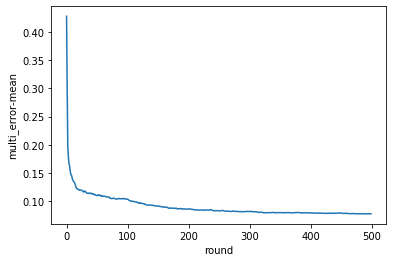

In [19]:
round_n = np.arange(len(gbm_result['multi_error-mean']))
plt.xlabel('round')
plt.ylabel('multi_error-mean')
plt.plot(round_n, gbm_result['multi_error-mean'])
plt.show()

Predict test data and save the result.

In [0]:
# lgb.plot_importance(gbm)
# plt.show()

In [0]:
# yHatTest_gbm_raw = gbm.predict(X_test)
# yHatTest_gbm = np.argmax(yHatTest_gbm_raw, axis=1)
# np.savetxt(root_dir+'result_gbm2.txt', yHatTest_gbm)

In [0]:
yHatTest = clf.predict(X_test)
np.savetxt(root_dir+'result_svm.txt', yHatTest)